#  Build a Neural network with Hyper-parameter fine tuning model

In [2]:
import numpy as np
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.datasets import fashion_mnist
from keras_tuner import RandomSearch

In [3]:
Trails=2 
epochs=3 

# Get the fashion_MNIST dataset

In [5]:
(xtrain,ytrain),(xval,yval)=fashion_mnist.load_data()
xtrain=np.expand_dims(xtrain.astype('float32')/255.,-1)
xval=np.expand_dims(xval.astype('float32')/255.,-1)
ytrain=to_categorical(ytrain,10)
yval=to_categorical(yval,10)

In [11]:
def build_model(hp):
    """
    Function to build a TF model based on hyperparameter values
    
    Args:
    hp (hyperparameter): values
    
    Returns:
    Model: compiled model
    """
    num_layers = hp.Int('num_layers', 2, 8, default=6)
    lr = hp.Choice('learning_rate', [0.0001, 0.05])
    inputs = layers.Input(shape=(28, 28, 1))
    x = inputs
    for idx in range(num_layers):
        idx_str = str(idx)
        filters = hp.Int('filters_' + idx_str, 32, 256, step=32, default=64)
        x = layers.Conv2D(filters=filters, kernel_size=3, padding='same', activation='relu')(x)

        if x.shape[1] >= 8:
            pool_type = hp.Choice('pool_' + idx_str, values=['max', 'avg'])
            if pool_type == 'max':
                x = layers.MaxPooling2D(2)(x)
            elif pool_type == 'avg':
                x = layers.AveragePooling2D(2)(x)

    x = layers.Flatten()(x)
    outputs = layers.Dense(10, activation='softmax')(x)

    # Build model
    model = keras.Model(inputs, outputs)
    model.compile(optimizer=Adam(lr), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [12]:
tuner=RandomSearch(build_model,objective='val_accuracy',max_trials=Trails,
                  project_name='FASHION_MNIST_results')

In [13]:
tuner.search_space_summary()

Search space summary
Default search space size: 10
num_layers (Int)
{'default': 6, 'conditions': [], 'min_value': 2, 'max_value': 8, 'step': 1, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.0001, 'conditions': [], 'values': [0.0001, 0.05], 'ordered': True}
filters_0 (Int)
{'default': 64, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
pool_0 (Choice)
{'default': 'max', 'conditions': [], 'values': ['max', 'avg'], 'ordered': False}
filters_1 (Int)
{'default': 64, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
pool_1 (Choice)
{'default': 'max', 'conditions': [], 'values': ['max', 'avg'], 'ordered': False}
filters_2 (Int)
{'default': 64, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
filters_3 (Int)
{'default': 64, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
filters_4 (Int)
{'default': 64, 'conditions': [], 'min_value

In [14]:
tuner.search_space_summary

<bound method BaseTuner.search_space_summary of <keras_tuner.src.tuners.randomsearch.RandomSearch object at 0x0000016060664F50>>

In [15]:
tuner.search(xtrain,ytrain,batch_size=128,epochs=2,validation_data=(xval,yval))

Trial 2 Complete [00h 12m 01s]
val_accuracy: 0.8118000030517578

Best val_accuracy So Far: 0.8434000015258789
Total elapsed time: 00h 32m 12s


In [16]:
tuner.results_summary()

Results summary
Results in .\FASHION_MNIST_results
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0 summary
Hyperparameters:
num_layers: 8
learning_rate: 0.0001
filters_0: 160
pool_0: max
filters_1: 192
pool_1: avg
filters_2: 64
filters_3: 256
filters_4: 256
filters_5: 192
filters_6: 64
filters_7: 64
Score: 0.8434000015258789

Trial 1 summary
Hyperparameters:
num_layers: 4
learning_rate: 0.05
filters_0: 192
pool_0: max
filters_1: 160
pool_1: avg
filters_2: 32
filters_3: 32
filters_4: 160
filters_5: 160
filters_6: 160
filters_7: 96
Score: 0.8118000030517578


In [17]:
best_model=tuner.get_best_models(num_models=1)[0]
best_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 160)       1600      
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 160)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 192)       276672    
                                                                 
 average_pooling2d (Average  (None, 7, 7, 192)         0         
 Pooling2D)                                                      
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          110656

# Build an image classifier model with Pytorch

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms


In [17]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 4
trainset = torchvision.datasets.SVHN(root='./data', split='train',
                                     download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.SVHN(root='./data', split='test',
                                    download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = tuple(str(i) for i in range(10))


100%|███████████████████████████████████████████████████████████████| 182040794/182040794 [00:45<00:00, 4034582.29it/s]


100%|█████████████████████████████████████████████████████████████████| 64275384/64275384 [00:39<00:00, 1607292.28it/s]


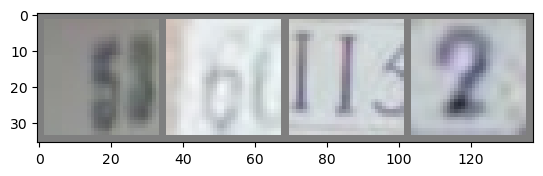

5     6     1     2    


In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Function to show an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))

# Print labels
batch_size = len(labels)  # Adjusting batch_size to the actual number of labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))


In [19]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()


In [20]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


# Train The network


In [21]:
for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:  # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')






[1,  2000] loss: 2.250
[1,  4000] loss: 2.225
[1,  6000] loss: 1.956
[1,  8000] loss: 1.220
[1, 10000] loss: 0.833
[1, 12000] loss: 0.726
[1, 14000] loss: 0.636
[1, 16000] loss: 0.601
[1, 18000] loss: 0.544
[2,  2000] loss: 0.519
[2,  4000] loss: 0.503
[2,  6000] loss: 0.487
[2,  8000] loss: 0.484
[2, 10000] loss: 0.472
[2, 12000] loss: 0.455
[2, 14000] loss: 0.447
[2, 16000] loss: 0.449
[2, 18000] loss: 0.415
Finished Training


In [24]:
PATH = './svhn_net.pth'
torch.save(net.state_dict(), PATH)

# Test the network on the test data

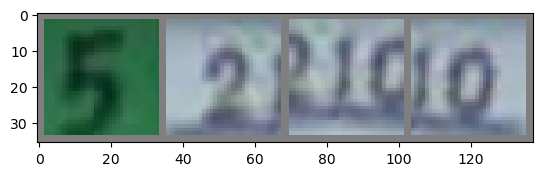

GroundTruth:  5     2     1     0    


In [23]:
dataiter = iter(testloader)
images, labels = next(dataiter)
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(len(labels))))


In [25]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [26]:
outputs = net(images)

In [27]:
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
 for j in range(4)))

Predicted:  5     2     1     0    


In [28]:
correct = 0
total = 0

# Since we're not training, we don't need to calculate the gradients for ou
with torch.no_grad():
    for data in testloader:
        images, labels = data

        # Calculate outputs by running images through the network
        outputs = net(images)

        # The class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total}%')


Accuracy of the network on the 10000 test images: 86.18239090350338%


In [29]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# Again, no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)

        # Collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# Print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')


Accuracy for class: 0     is 83.3 %
Accuracy for class: 1     is 92.2 %
Accuracy for class: 2     is 89.6 %
Accuracy for class: 3     is 81.8 %
Accuracy for class: 4     is 86.2 %
Accuracy for class: 5     is 87.9 %
Accuracy for class: 6     is 78.5 %
Accuracy for class: 7     is 86.3 %
Accuracy for class: 8     is 72.5 %
Accuracy for class: 9     is 90.2 %
